# TL072/TL082 Analysis and Simulation

By Shuo Chen (chenshuo_at_chenshuo.com) [30% done]

Latest version: https://chenshuo.github.io/notes/TL082/

Jupyter source of this page: https://github.com/chenshuo/notes/blob/master/notebooks/TL082.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

In [1]:
%matplotlib inline

import math
from math import degrees, exp, log, log10, sqrt

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt
import scipy

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-6:
            print('%10s = %8.2f uA' % (k, 1e6*current))
        else:
            print('%10s = %8.2f nanoA' % (k, 1e9*current))
    else:
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 1.5:
            print('%10s = %8.3f V' % (k, voltage))
        else:
            print('%10s = %8.2f mV' % (k, 1e3*voltage))

TL082/TL072 are general purpose JFET-input op amps (a.k.a. Bi-FET technology), first introduced by Texas Instruments in 1977.

> *Note:* This post doesn't talk about new TL07xH/TL08xH opamps introduced in 2020, which are CMOS opamps. We focus on those classic JFET input op amps.

The following table shows brief specs for TL072C from [TI 1996 datasheet](https://nuedc.org/opamp/tl072-1996.pdf)

| Parameter | Symbol | Unit | min | typical | max |
| --- | :-: | :-: | --: | --: | --: |
| Offset voltage | Vos | mV |    | 3   | 10  |
| Bias current | $I_{B}$ | pA |  | 65 | 200 |
| Input resistance | $R_{id}$ | Ω | | $10^{12}$ | |
| Common-mode input voltage range | $V_{CM}$ | V | $\pm 11$ | $-$12 to 15| |
| Unit-gain bandwidth | GBW | MHz | | 3 | |
|Open-loop voltage gain| $A_{VD}$ | V/mV| 25 | 200 | |
| Slew rate | SR | V/μsec | 8 | 13 | |
| Supply current (per amp) | $I_Q$ | mA | | 1.4 | 2.5 |
| Input voltage noise density | $e_N$ | nV/$\sqrt{\mathrm{Hz}}$ | | 18 | |
| Total harmonic distrortion | THD | | | 0.003% | |

In the past, TL072 and TL082 had slightly different specs (TL082 had higher input voltage noise etc.), now they are essential the same chip, see [TL082 1999 datasheet](https://nuedc.org/opamp/tl082-1999.pdf) for comparison.

## History

TL08x was announced in [mid 1976](https://nuedc.org/opamp/tl081-1976.pdf) and [released early 1977](https://nuedc.org/opamp/tl082-1977feb.pdf), TL06x and TL072x were added to the family [later that year](https://nuedc.org/opamp/tl072-1977sep.pdf). Back then, there were three series:

| Selling point | Single | Dual | Quad | Features |
| --- | :-: | :-: | :-: | --- |
| General purpose | TL081 | TL082 | TL084 | input voltage noise 25 nV/$\sqrt{\mathrm{Hz}}$ |
| Low noise |TL071 | TL072 | TL074 | input voltage noise 18 nV/$\sqrt{\mathrm{Hz}}$ |
| Low power |TL061 | TL062 | TL064 | supply current is 200μA per amp, but gain is as low as 6,000 (75.6dB)|

Those op amps have internal frequency compensation ($C_c=18$pF), except TL060, TL070 and TL080.

National's [LF355/LF356/LF357](https://nuedc.org/opamp/lf156-1980.pdf) ([released in 1975](https://nuedc.org/opamp/lf156-1975.pdf)) were first Bi-FET opamps that made with [ion implantation technique](https://doi.org/10.1109/ISSCC.1974.1155311). which produces well-matched JFETs. So the input offset voltage of LF35x were made as low as typical BJT op amps (1~3 mV). However the cost of LF35x was high because [it incorporates 4 pairs of JFETs](https://nuedc.org/opamp/tl082-1978jan.pdf) and is about twice the die size of a μA741.
TL081 contains only one pair of input JFETs, and is about the same size of a μA741.

National announced low-cost [LF351](https://nuedc.org/opamp/lf351-1980.pdf)/[LF353](https://nuedc.org/opamp/lf353-1980.pdf)/[LF347](https://nuedc.org/opamp/lf347-1980.pdf) op amps in [late 1977](https://nuedc.org/opamp/lf353-1977sep.pdf), in response to TI's TL07x/TL08x series.
Although National's chips had [somewhat improved circuit and specs](https://nuedc.org/opamp/tl072-jlh1982.pdf), TL082 and LF353 are often interchangeable.

In late 1980s, TI sells [its own LF351/LF353/LF347](https://nuedc.org/opamp/lf353-ti1989.pdf) op amps, which were probably just relabled TL071/TL072/TL074 respectively.
Meanthile, National sells [its own TL081/TL082](https://nuedc.org/opamp/tl082-ns1995.pdf), from the schematics we could tell that those were relabeled LF351/LF353 respectively.

Most interestingly, National was acquired by TI in 2011, its authentic LF353 had to be renamed LF353-N.

| Origin | LF353 | TL082 |
| --- | --- | --- |
| National | [LF353-N](https://www.ti.com/lit/ds/symlink/lf353-n.pdf) | [TL082-N](https://www.ti.com/lit/ds/symlink/tl082-n.pdf) |
| TI | [LF353](https://www.ti.com/lit/ds/symlink/lf353.pdf) | [TL082](https://www.ti.com/lit/ds/symlink/tl082.pdf) |

In [2]:
# Circuitikz μA kΩ
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

## Analysis of circuit

The following is a simplified schematic of TL072/TL082, it's a typical two-stage single-pole op amp.

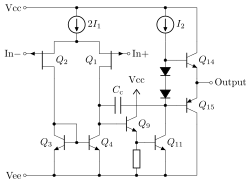

In [16]:
%%tikz -ct -f svg

TI didn't reveal the values of most resistors in its datasheets, but we can made educated guess based on the specs and formulas from James E. Solomon's 1974 classic paper [The Monolithic Op Amp: A Tutorial Study](https://web.ece.ucsb.edu/Faculty/rodwell/Classes/ece2c/resources/an-a.pdf).

First from formula (18), slew rate$=\displaystyle\frac{2I_1}{C_c}=13$V/μsec, with $C_c=18$pF, we know $I_1=117$μA, which is the bias current of both JFETs ($I_D$).

Second from formula (16), unity-gain bandwidth $f=\displaystyle\frac{g_{m1}}{2\pi C_c}=3$MHz, we know $g_{m1} \approx 0.34$mS.



For [JFET in saturation region](https://leachlegacy.ece.gatech.edu/ece3050/notes/jfet/thejfet.pdf), $i_D = I_{DSS}\displaystyle\Big(1-\frac{v_{GS}}{V_{TO}}\Big)^2 = \beta(v_{GS}-V_{TO})^2$, where $I_{DSS} = \beta\, V_{TO}^2$.

> Note $\beta$ here is s SPICE parameter of JFET model, it has nothing to do with BJT's current gain.

In small-signal model, $g_m=2\beta(V_{GS}-V_{TO})=2\sqrt{\beta I_D}$

Given $I_D=117$μA and $g_m=0.34$mS, we calculate $\beta = \displaystyle (\frac{g_m}{2})^2 \frac{1}{ I_D}\approx 0.246$ mA/V${{}^2}$


Next, we estimate the bias curent of the 2nd stage $I_2$.

Next, we calculate the open-loop gain.

## Simulation